# N-best PCA components

In this notebook, we will be decomposing the MNIST training and testing set data into their respective eigenvectors and eigenvalues such that the images can be reconstructed using the N-best PCA components (ones that contribute the most to image detail).
The PCA algorithm depends on a covariance matrix given by:
$$\Sigma(X) \equiv V \Lambda V^T$$
where $V$ is a matrix whose columns are the eigenvectors and $\Lambda$ is a diagonal matrix whose elements are the eigenvalues.

## Import Modules
As always, we will need to import the necessary modules for our system.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from scipy import linalg

## Neural Network
Time to load the MNIST training and testing sets (images and labels) into usable variables. The images are denoted by `x_` and the labels are denoted by `y_`. The images will then need to be normalised and reshaped to match the length of their eigenvalues and eigenvectors          
($28 * 28 = 784$ long).

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data() # load MNIST training and test images with labels

# normalise data
x_train = x_train.reshape(60000, 784) / 255.0 # reshape and normalise training images
x_test = x_test.reshape(10000, 784) / 255.0 # reshape and normalise testing images

Now to define our neural network of 2 hidden dense layers and one output layer of 10 nodes. Convolutional and pooling layers have not been used here for run-time purposes. The network is then compiled, trained on the MNIST training set and tested on the MNIST testing set.

In [ ]:
# create neural network of 2 dense layers + 1 dense output layer
model = keras.models.Sequential()
model.add(keras.layers.Dense(128, activation='relu', input_shape=(784,)))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

# compile network
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=64, epochs=5) # train network
test_loss, test_acc = model.evaluate(x_test, y_test, verbose = 2) # test network

Epoch 1/5


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


938/938 [==============================] - 10s 9ms/step - loss: 0.2778 - accuracy: 0.9205
Epoch 2/5
938/938 [==============================] - 8s 8ms/step - loss: 0.1158 - accuracy: 0.9656
Epoch 3/5
938/938 [==============================] - 4s 5ms/step - loss: 0.0796 - accuracy: 0.9758
Epoch 4/5
938/938 [==============================] - 6s 6ms/step - loss: 0.0595 - accuracy: 0.9807
Epoch 5/5
938/938 [==============================] - 7s 7ms/step - loss: 0.0458 - accuracy: 0.9853
313/313 - 2s - loss: 0.0742 - accuracy: 0.9766 - 2s/epoch - 5ms/step


Now that our network has been sufficiently trained such that it is achieving >95% testing accuracy, we can begin to implement the PCA algorithm.
## N-best PCA components Testing Dataset
We can use the PCA algorithm to decompose our testing image set and reconstruct it using the N-best PCA components (that we have explicitly chosen). We can then test our network trained above on this new testing set constructed out of different numbers of PCA components to see the effects on the accuracy achieved. Note: 748 PCA components would reconstruct the original image as this is the total number of such constituents.

313/313 [==============================] - 1s 2ms/step - loss: 0.0741 - accuracy: 0.9767


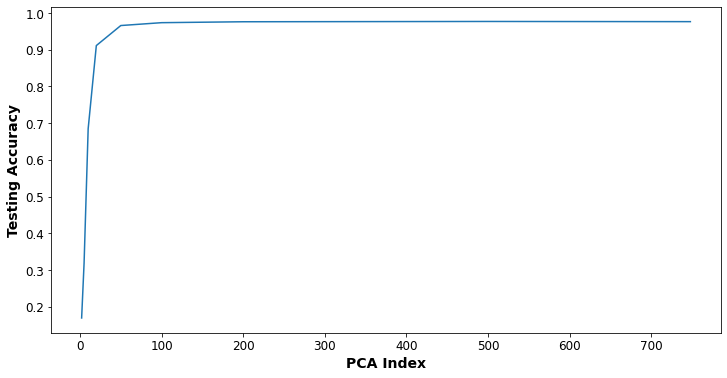

In [ ]:
def NBestTest(x_test,model):
  '''Decomposes the input MNIST test images into their eigenvectors and values
     and tests the accuracy of an input model on the N-Best PCA components shown
     on an outputted graph'''

  # decompose test images into eigenvectors and eigenvalues
  testmu=np.mean(x_test,axis=0) # mean value
  x=x_test-testmu
  rho=np.cov(x,rowvar=False) # covariance matrix
  testvals,testvecs=linalg.eigh(rho) # get eigenvalues and eigenvectors
  # flip arrays such that the first component is in the [0] position
  testvecs=np.flip(testvecs)
  testvals=np.flip(testvals)

  testP=np.dot(x,testvecs)
  N = [2,5,10,20,50,100,200,500,748] # N-best values
  accuracies = [] # initialise array for accuracy vals
  for n in N:
    newtestImage = (np.dot(testP[:,0:n],testvecs.T[0:n,:]))+testmu # new test images using n pca components
    test_loss, test_accuracy = model.evaluate(newtestImage, y_test) # test model on reconstructed images
    accuracies.append(test_accuracy) # update accuracy

  # plot N-best PCA values against testing accuracy
  fig = plt.figure(figsize=(12, 6))
  plt.plot(N, accuracies)
  plt.xlabel('PCA Index', fontsize = 14, fontweight = 'heavy')
  plt.ylabel('Testing Accuracy', fontsize = 14, fontweight = 'heavy')
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)

  return accuracies

fulltrained = NBestTest(x_test,model) # test initially trained model on new test set

The graph above shows that the accuracy increases with the more PCA components that we use to construct our test images. This is expected as with a really low number of PCA components, the images are being reconstructed with minimal information and so the number contained within each image would be highly unintelligble, leading to low accuracies. The test accuracy is found to plateau after around 50 PCA components are being used to construct the test set, suggesting that the reconstructed images are close enough/resemblant of the original, such that the network can achieve almost the same testing accuracy as it can with the unchanged MNIST testing set. In the real world, this signifies that images can be decomposed and represented by less information for a neural network to achieve an acceptable performance when recognising what is contained within the image. This would help with reducing file size and computational power.

## N-best PCA components Training Dataset
Now we can investigate what would happen to the testing accuracy if we trained our network on images that are decomposed into their N-best PCA components. Firstly, we can look at this effect when we use the 100 best PCA components of the training images to train our network, and then train the network again but this time with a training set using the 20 best PCA components.

In [ ]:
def NBestTrain(x_train,x_test,model,nbest):
  '''Decomposes the input MNIST training images into their eigenvalues and
     eigenvectors before retraining an input model on the N-best PCA components.
     This model is then tested through the `NBestTest` function where its accuracy
     is measured on test images reconstructed at different N-best values.'''

  # decompose training images into eigenvectors and eigenvalues
  trainmu=np.mean(x_train,axis=0)
  x=x_train-trainmu
  rho=np.cov(x,rowvar=False) # Make the covaraince matrix
  #Get the eigenvalues and vectors and correct their order
  trainvals,trainvecs=linalg.eigh(rho)
  trainvecs=np.flip(trainvecs)
  trainvals=np.flip(trainvals)

  trainP=np.dot(x,trainvecs) # dot product of x and its vectors
  newTraining = (np.dot(trainP[:,0:nbest],trainvecs.T[0:nbest,:]))+trainmu # new training set of 100 best PCA components
  print("Training:")
  model.fit(newTraining, y_train, batch_size=64, epochs=5) # train network on new training set

  print("\n Testing:")
  acc = NBestTest(x_test,model) # test on new testing sets of N-best PCA components
  return acc

Training:
Epoch 1/5
938/938 [==============================] - 6s 6ms/step - loss: 0.2750 - accuracy: 0.9210
Epoch 2/5
938/938 [==============================] - 4s 5ms/step - loss: 0.1175 - accuracy: 0.9653
Epoch 3/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0864 - accuracy: 0.9732
Epoch 4/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0693 - accuracy: 0.9788
Epoch 5/5
938/938 [==============================] - 4s 5ms/step - loss: 0.0560 - accuracy: 0.9822

 Testing:
313/313 [==============================] - 1s 2ms/step - loss: 0.0704 - accuracy: 0.9795


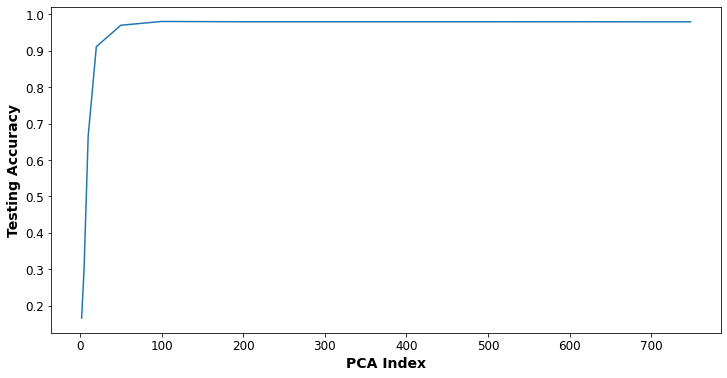

In [ ]:
# redefine the same network
model2 = keras.models.Sequential()
model2.add(keras.layers.Dense(128, activation='relu', input_shape=(784,)))
model2.add(keras.layers.Dense(64, activation='relu'))
model2.add(keras.layers.Dense(10, activation='softmax'))

# compile network
model2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
trained100 = NBestTrain(x_train,x_test,model2,100) # train on 100 best components

Training:
Epoch 1/5
938/938 [==============================] - 5s 5ms/step - loss: 0.3609 - accuracy: 0.8917
Epoch 2/5
938/938 [==============================] - 6s 6ms/step - loss: 0.1709 - accuracy: 0.9474
Epoch 3/5
938/938 [==============================] - 6s 6ms/step - loss: 0.1355 - accuracy: 0.9583
Epoch 4/5
938/938 [==============================] - 5s 6ms/step - loss: 0.1160 - accuracy: 0.9649
Epoch 5/5
938/938 [==============================] - 6s 6ms/step - loss: 0.1046 - accuracy: 0.9686

 Testing:
313/313 [==============================] - 1s 2ms/step - loss: 0.1455 - accuracy: 0.9566


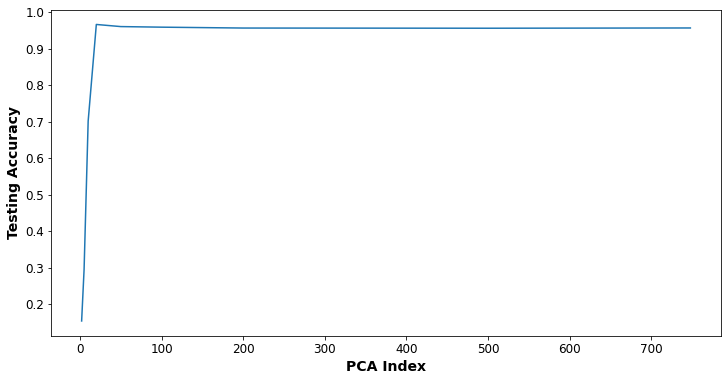

In [ ]:
# redefine the same network
model3 = keras.models.Sequential()
model3.add(keras.layers.Dense(128, activation='relu', input_shape=(784,)))
model3.add(keras.layers.Dense(64, activation='relu'))
model3.add(keras.layers.Dense(10, activation='softmax'))

# compile network
model3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
trained20 = NBestTrain(x_train,x_test,model3,20) # retrain on 20 best components

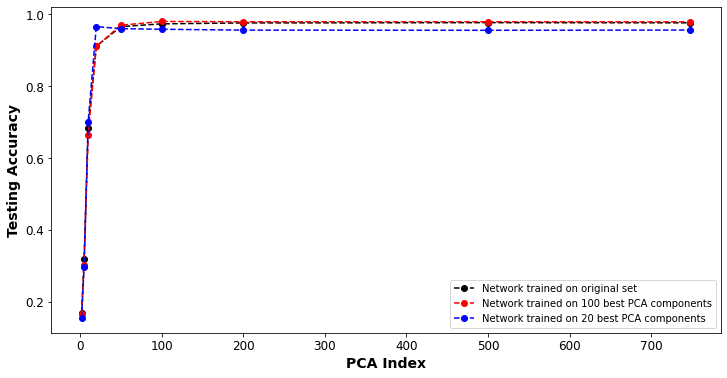

In [ ]:
N = [2,5,10,20,50,100,200,500,748] # N-best values

# plot overlayed graph
fig = plt.figure(figsize=(12, 6))
plt.plot(N, fulltrained, '--o', label = 'Network trained on original set', color = 'black') # original
plt.plot(N, trained100, '--o', label = 'Network trained on 100 best PCA components', color = 'red') # 100-best
plt.plot(N, trained20, '--o', label = 'Network trained on 20 best PCA components', color = 'blue') # 20-best
plt.xlabel('PCA Index', fontsize = 14, fontweight = 'heavy')
plt.ylabel('Testing Accuracy', fontsize = 14, fontweight = 'heavy')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

## Analysis
When training with the 100-best PCA components (red), we find an almost identical agreement with the network trained using the original MNIST training set (black). This was discussed earlier, in that the images can be almost identically replicated (in the eyes of the network) by just the first 100 best PCA components. This has big implications for image simplification as only around 13% of components can be used to achieve an almost identical network testing performance. We find a major distinction in the network trained using the 20-best PCA components (blue), where the testing accuracy peaks before plateauing, coinciding with a PCA Index of 20. This kind of network achieves a distinguishably lower accuracy than the other two for testing images consisting of 50 or more PCA components, although it has a better testing performance for images that consist of a similar number of PCA components as the amount that was used in the training process (~20). This is explained by the fact that the network is better at identifying images that are most similar to the ones that it was trained on. For the MNIST data set, if image simplification is of priority then I predict the best network testing performance would be achieved when it is trained on ~50 PCA components, as we have identified earlier that this amount leads to a highly acceptable accuracy/performance for only 6.7% of the total number of components.